# Advanced DL and RL: Домашнее задание 2  
Второе домашнее задание опять посвящено игре; его базовая часть, надеюсь, не слишком большая, но я добавил опциональную часть, которая, думаю, должна быть достаточно интересной для любого слушателя. Как обычно, в качестве решения ожидается ссылка на jupyter-ноутбук на вашем github (или публичный, или с доступом для snikolenko); ссылку обязательно нужно прислать в виде сданного домашнего задания на портале Академии. Любые комментарии, новые идеи и рассуждения на тему, как всегда, категорически приветствуются.  

In [1]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt

import gym
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.autograd import Variable
device = torch.device("cuda") if torch.cuda.is_available() else torch.device('cpu')

## Часть первая: крестики-нолики при помощи Q-обучения  
В коде, прилагающемся к последней лекции про обучение с подкреплением, реализован Environment для крестиков-ноликов, в котором можно при инициализации указывать разные размеры доски и условия победы, а также функции для рисования, в том числе с указанием оценки различных действий. С этим окружением все задания и связаны.  

In [2]:
class TicTacToe(gym.Env):
    def __init__(self, n_rows, n_cols, n_win):
        self.n_rows = n_rows
        self.n_cols = n_cols
        self.n_win = n_win

        self.board = np.zeros((self.n_rows, self.n_cols), dtype=int)
        self.gameOver = False
        self.boardHash = None
        # ход первого игрока
        self.curr_turn = 1
        self.empty_spaces = None
        
        self.reset()

    def getEmptySpaces(self):
        if self.empty_spaces is None:
            res = np.where(self.board == 0)
            self.empty_spaces = np.array([ (i, j) for i,j in zip(res[0], res[1]) ])
        return self.empty_spaces

    def makeMove(self, player, i, j):
        self.board[i, j] = player
        self.empty_spaces = None
        self.boardHash = None

    def getHash(self):
        if self.boardHash is None:
            self.boardHash = ''.join(['%s' % (x+1) for x in self.board.reshape(self.n_rows * self.n_cols)])
        return self.boardHash

    def isTerminal(self):
        # проверим, не закончилась ли игра
        cur_marks, cur_p = np.where(self.board == self.curr_turn), self.curr_turn
        for i,j in zip(cur_marks[0], cur_marks[1]):
#             print((i,j))
            win = False
            if i <= self.n_rows - self.n_win:
                if np.all(self.board[i:i+self.n_win, j] == cur_p):
                    win = True
            if not win:
                if j <= self.n_cols - self.n_win:
                    if np.all(self.board[i,j:j+self.n_win] == cur_p):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j <= self.n_cols - self.n_win:
                    if np.all(np.array([ self.board[i+k,j+k] == cur_p for k in range(self.n_win) ])):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j >= self.n_win-1:
                    if np.all(np.array([ self.board[i+k,j-k] == cur_p for k in range(self.n_win) ])):
                        win = True
            if win:
                self.gameOver = True
                return self.curr_turn

        if len(self.getEmptySpaces()) == 0:
            self.gameOver = True
            return 0

        self.gameOver = False
        return None

    def printBoard(self):
        for i in range(0, self.n_rows):
            print('----'*(self.n_cols)+'-')
            out = '| '
            for j in range(0, self.n_cols):
                if self.board[i, j] == 1:
                    token = 'x'
                if self.board[i, j] == -1:
                    token = 'o'
                if self.board[i, j] == 0:
                    token = ' '
                out += token + ' | '
            print(out)
        print('----'*(self.n_cols)+'-')

    def getState(self):
        return (self.getHash(), self.getEmptySpaces(), self.curr_turn)

    def action_from_int(self, action_int):
        return ( int(action_int / self.n_cols), int(action_int % self.n_cols))

    def int_from_action(self, action):
        return action[0] * self.n_cols + action[1]
    
    def step(self, action):
        if self.board[action[0], action[1]] != 0:
            return self.getState(), -10, True, {}
        self.makeMove(self.curr_turn, action[0], action[1])
        reward = self.isTerminal()
        self.curr_turn = -self.curr_turn
        return self.getState(), 0 if reward is None else reward, reward is not None, {}

    def reset(self):
        self.board = np.zeros((self.n_rows, self.n_cols), dtype=int)
        self.boardHash = None
        self.gameOver = False
        self.empty_spaces = None
        self.curr_turn = 1

1. Реализуйте обычное (табличное) Q-обучение. Обучите стратегии крестиков и ноликов для доски 3х3.

In [3]:
class  RandomPolicy:
    def move(self, env, *args, **kwargs):
        board_hash, empty_spaces, player = env.getState()
        return np.random.randint(len(empty_spaces))

In [4]:
class EspGreedyPolicy:
    def __init__(self):
        self.Q = {}
        
    def move(self, env, epsilon, *args, **kwargs):
        board_hash, empty_spaces, player = env.getState()
        if (random.random() > epsilon) and (board_hash in self.Q):
                return np.argmax(self.Q[board_hash])
        elif board_hash in self.Q:
                return np.random.randint(len(empty_spaces))
        else:
            self.Q[board_hash] = np.zeros(len(empty_spaces))
            return np.random.randint(len(empty_spaces))

### Будем обучать стратегии крестиков и ноликов одновременно друг на друге, а оценивать прогресс на случайной стратегии

In [10]:
def generate_episode(env, policy_1, policy_2, *args, **kwargs):
    env.reset()
    board_hash, empty_spaces, curr_turn = env.getState()
    reward = 0
    done = False
    pi_1_prev_board_hash = None
    pi_1_prev_action_num = None
    pi_2_prev_board_hash = None
    pi_2_prev_action_num = None
    while not done:
        if curr_turn == 1:
            action_num = policy_1.move(env, *args, **kwargs)
            state, reward, done, _ = env.step(empty_spaces[action_num])
            if reward == 1:
                  policy_1.Q[board_hash][action_num] = reward
            
            # Use new state and reward to update policy_2 weights
            board_hash_next, empty_spaces_next, curr_turn_next = state
            if pi_2_prev_board_hash is not None:
                gamma_term = gamma * np.max(policy_2.Q[board_hash_next]) if board_hash_next in policy_2.Q else 0
                policy_2.Q[pi_2_prev_board_hash][pi_2_prev_action_num] +=  alpha * (-reward + gamma_term -
                                                                                    policy_2.Q[pi_2_prev_board_hash][pi_2_prev_action_num])
            
            pi_1_prev_board_hash = board_hash
            pi_1_prev_action_num = action_num
        else:
            action_num = policy_2.move(env, *args, **kwargs)
            state, reward, done, _ = env.step(empty_spaces[action_num])
            if reward == -1:
                policy_2.Q[board_hash][action_num] = -reward
            
            # Use new state and reward to update policy_1 weights
            board_hash_next, empty_spaces_next, curr_turn_next = state
            if pi_1_prev_board_hash is not None:
                gamma_term = gamma * np.max(policy_1.Q[board_hash_next]) if board_hash_next in policy_1.Q else 0
                policy_1.Q[pi_1_prev_board_hash][pi_1_prev_action_num] += alpha * (reward + gamma_term - 
                                                                                   policy_1.Q[pi_1_prev_board_hash][pi_1_prev_action_num])
            
            pi_2_prev_board_hash = board_hash
            pi_2_prev_action_num = action_num
        
        board_hash, empty_spaces, curr_turn = board_hash_next, empty_spaces_next, curr_turn_next

In [11]:
def play_game(env, policy_1, policy_2, *args, **kwargs):
    env.reset()
    board_hash, empty_spaces, curr_turn = env.getState()
    reward = 0
    done = False
    while not done:
        if curr_turn == 1:
            action = policy_1.move(env, *args, **kwargs)
        else:
            action = policy_2.move(env, *args, **kwargs)
            
        state, reward, done, _ = env.step(empty_spaces[action])
        board_hash, empty_spaces, curr_turn = state
    return reward

In [12]:
def test_policy(env, policy_1, policy_2, num_episodes, epsilon):
    total_reward = 0
    for _ in range(num_episodes):
        total_reward += play_game(env, policy_1, policy_2, epsilon)
    return total_reward / num_episodes

In [13]:
env = TicTacToe(3, 3, 3)
policy_1 = EspGreedyPolicy()
policy_2 = EspGreedyPolicy()
policy_random = RandomPolicy()

total_episodes = 100000
alpha, gamma = 0.015, 1.0
epsilon, epsilon_min, epsilon_decay = 0.9, 0.01, 0.999975
test_period, num_episodes = 1000, 800
idx = []
crosses = []
noughts = []

for i in tqdm(range(1, total_episodes + 1)):
    generate_episode(env, policy_1, policy_2, alpha, gamma, epsilon)
    epsilon = max(epsilon_min, epsilon * epsilon_decay)
    if i % test_period == 0:
        cross = test_policy(env, policy_1, policy_random, num_episodes, 0.)
        nought = -test_policy(env, policy_random, policy_2, num_episodes, 0.)
        idx.append(i)
        crosses.append(cross)
        noughts.append(nought)

100%|████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [01:46<00:00, 938.53it/s]


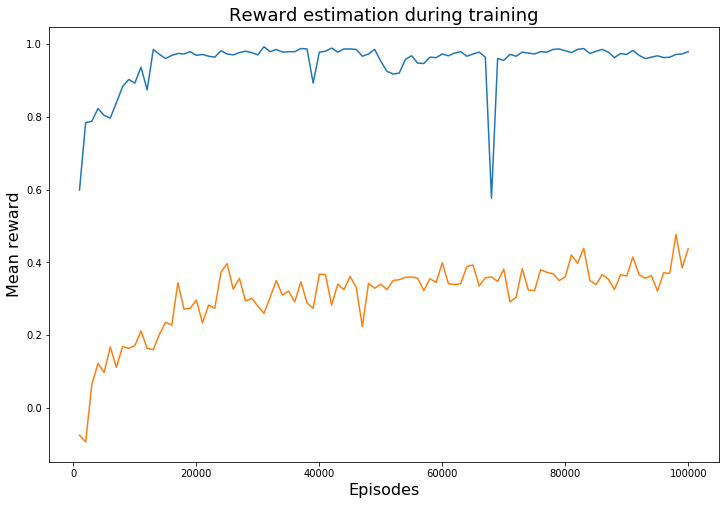

In [14]:
plt.figure(figsize = (12, 8))
plt.title('Reward estimation during training', fontsize=18)
plt.xlabel('Episodes', fontsize=16)
plt.ylabel('Mean reward', fontsize=16)
plt.plot(idx, crosses, label='Crosses')
plt.plot(idx, noughts, label='Noughts')
plt.show()

2. Попробуйте обучить стратегии крестиков и ноликов для доски 4х4 и/или 5х5.

In [15]:
env = TicTacToe(4, 4, 4)
policy_1 = EspGreedyPolicy()
policy_2 = EspGreedyPolicy()
policy_random = RandomPolicy()

total_episodes = 2000000
alpha, gamma = 0.015, 0.8
epsilon, epsilon_min, epsilon_decay = 0.9, 0.01, 0.9999975
test_period, num_episodes = 5000, 1000
idx = []
crosses = []
noughts = []

for i in tqdm(range(1, total_episodes + 1)):
    generate_episode(env, policy_1, policy_2, alpha, gamma, epsilon)
    epsilon = max(epsilon_min, epsilon * epsilon_decay)
    if i % test_period == 0:
        cross = test_policy(env, policy_1, policy_random, num_episodes, 0.)
        nought = -test_policy(env, policy_random, policy_2, num_episodes, 0.)
        idx.append(i)
        crosses.append(cross)
        noughts.append(nought)

100%|██████████████████████████████████████████████████████████████████████████████████| 2000000/2000000 [48:37<00:00, 685.48it/s]


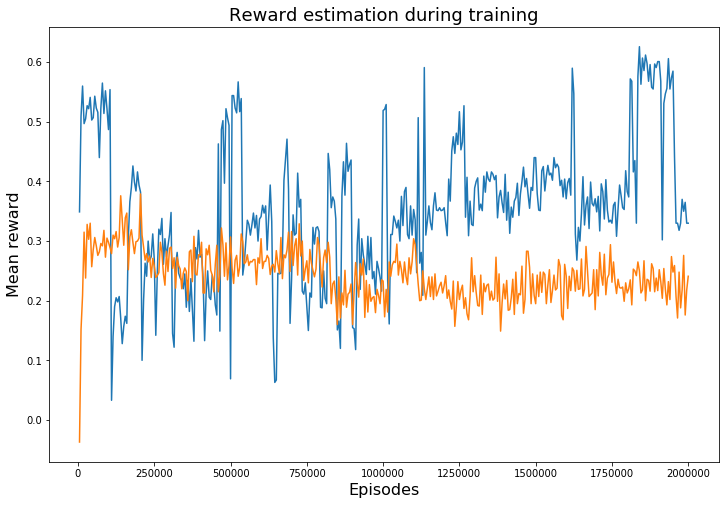

In [16]:
plt.figure(figsize = (12, 8))
plt.title('Reward estimation during training', fontsize=18)
plt.xlabel('Episodes', fontsize=16)
plt.ylabel('Mean reward', fontsize=16)
plt.plot(idx, crosses, label='Crosses')
plt.plot(idx, noughts, label='Noughts')
plt.show()

## Часть вторая: добавим нейронных сетей
Реализуйте нейронную сеть для метода DQN на доске для крестиков-ноликов. Не буду ограничивать фантазию, но кажется, что свёртки 3х3 здесь должны неплохо работать (в том числе обобщаться на доски размера побольше).

3. Реализуйте DQN с нейронной сетью, обучите стратегии крестиков и ноликов. Замечание: скорее всего, experience replay потребуется сразу же.  

In [3]:
class ReplayMemory():
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def store(self, exptuple):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = exptuple
        self.position = (self.position + 1) % self.capacity
       
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)

In [4]:
class Network_3_3(nn.Module):
    def __init__(self, conv_out=128):
        nn.Module.__init__(self)
        self.conv = nn.Conv2d(3, conv_out * 2, (3, 3))
        self.linear_1 = nn.Linear(conv_out * 2, conv_out)
        self.linear_2 = nn.Linear(conv_out, 9)

    def forward(self, x):
        x = F.relu(self.conv(x))
        x = torch.flatten(x, 1)
        x = F.relu(self.linear_1(x))
        x = self.linear_2(x)
        return x
    
class Network_4_4(nn.Module):
    def __init__(self):
        nn.Module.__init__(self)
        self.conv_1 = nn.Conv2d(3, 32, (3, 3))
        self.conv_2 = nn.Conv2d(32, 128, (2, 2))
        self.linear_1 = nn.Linear(128, 64)
        self.linear_2 = nn.Linear(64, 16)

    def forward(self, x):
        x = F.relu(self.conv_1(x))
        x = F.relu(self.conv_2(x))
        x = torch.flatten(x, 1)
        x = F.relu(self.linear_1(x))
        x = self.linear_2(x)
        return x

In [5]:
class DQN():
    def __init__(self, n_rows, n_cols, n_win, model, device):
        self.n_rows = n_rows
        self.n_cols = n_cols
        self.env = TicTacToe(n_rows, n_cols, n_win)
        self.device = device
        self.models = {
            -1: model().to(device), 
            1: model().to(device)}
        self.memories = {
            -1: ReplayMemory(50000 * n_rows * n_cols), 
            1: ReplayMemory(50000 * n_rows * n_cols)}
        self.optimizers = {
            -1: optim.Adam(self.models[-1].parameters(), lr=1e-4, weight_decay=1e-3),
            1: optim.Adam(self.models[1].parameters(), lr=1e-4, weight_decay=1e-3)}
        self.previous_states = {
            -1: None, 
            1: None}
        self.previous_actions = {}
        
        self.gamma = 0.8
        self.batch_size = 256
        
        self.eps_init, self.eps_final, self.eps_decay = 0.9, 0.05, 100000
        self.num_step = 0

    def select_greedy_action(self, state, cur_turn):
        return self.models[cur_turn](state.unsqueeze(0)).data.max(1)[1].view(1, 1)

    def select_action(self, state, cur_turn):
        sample = random.random()
        self.num_step += 1
        eps_threshold = self.eps_final + (self.eps_init - self.eps_final) * math.exp(-1. * self.num_step / self.eps_decay)
        if sample > eps_threshold:
            return self.select_greedy_action(state, cur_turn)
        else:
            return torch.tensor([[random.randrange(self.n_rows * self.n_cols)]], dtype=torch.int64)

    def learn(self, cur_turn):
        if np.min([len(self.memories[cur_turn]), len(self.memories[-cur_turn])]) < self.batch_size:
            return
        
        # берём мини-батч из памяти
        transitions = self.memories[cur_turn].sample(self.batch_size)
        batch_state, batch_action, batch_next_state, batch_reward = zip(*transitions)

        batch_state = Variable(torch.stack(batch_state).to(self.device))
        batch_action = Variable(torch.cat(batch_action).to(self.device))
        batch_reward = Variable(torch.cat(batch_reward).to(self.device))
        batch_next_state = Variable(torch.stack(batch_next_state).to(self.device))
        
        # считаем значения функции Q
        Q = self.models[cur_turn](batch_state).gather(1, batch_action).reshape([self.batch_size])
        
        # оцениваем ожидаемые значения после этого действия
        Qmax = self.models[cur_turn](batch_next_state).detach().max(1)[0]
        Qnext = batch_reward + (self.gamma * Qmax)
        
        # и хотим, чтобы Q было похоже на Qnext -- это и есть суть Q-обучения
        loss = F.smooth_l1_loss(Q, Qnext)
        
        self.optimizers[cur_turn].zero_grad()
        loss.backward()
        self.optimizers[cur_turn].step()
        
    def state_to_tensor(self, s):
        s = np.array([int(c) for c in s])
        size = int(np.sqrt(len(s)))
        crosses = np.where(s == 2, 1, 0).reshape(size, size)
        noughts = np.where(s == 0, 1, 0).reshape(size, size)
        empty_spaces = np.where(s == 1, 1, 0).reshape(size, size)
        return torch.Tensor(np.stack([crosses, noughts, empty_spaces])).reshape(3, size, size)
    
    def run_episode(self, training):
        self.env.reset()
        self.previous_states = {
            -1: None, 
            1: None}
        self.previous_actions = {}
        state, _, cur_turn = self.env.getState()
        
        done = False
        while not done:
            state_tensor = self.state_to_tensor(state)
            with torch.no_grad():
                action_idx = self.select_action(state_tensor.to(self.device), cur_turn).cpu()
            
            self.previous_states[cur_turn] = state_tensor
            self.previous_actions[cur_turn] = action_idx
            action = self.env.action_from_int(action_idx.numpy()[0][0])
            (next_state, empty_spaces, cur_turn), reward, done, _ = self.env.step(action)
            state = next_state
            next_state_tensor = self.state_to_tensor(next_state)
            
            if reward == -10:
                transition = (state_tensor, action_idx, next_state_tensor, torch.tensor([reward], dtype=torch.float32))
                self.memories[cur_turn].store(transition)
            else:
                if self.previous_states[cur_turn] is not None:
                    if reward == -cur_turn: 
                        transition = (self.previous_states[-cur_turn], self.previous_actions[-cur_turn], 
                                      next_state_tensor, torch.tensor([1.0], dtype=torch.float32))
                        self.memories[-cur_turn].store(transition)
                    transition = (self.previous_states[cur_turn], self.previous_actions[cur_turn], 
                                  next_state_tensor, torch.tensor([reward * cur_turn], dtype=torch.float32))
                    self.memories[cur_turn].store(transition)

            if training:
                self.learn(cur_turn)
        
    def test_strategy(self, player, n_episodes=1000):
        rewards = []
        for _ in range(n_episodes):
            self.env.reset()
            state, empty_spaces, cur_turn = self.env.getState()
            done = False
            while not done:
                if cur_turn == player:
                    idx = self.select_greedy_action(self.state_to_tensor(state).to(device), player)
                    action = self.env.action_from_int(idx)
                else:
                    idx = np.random.randint(len(empty_spaces))
                    action = empty_spaces[idx]
                (state, empty_spaces, cur_turn), reward, done, _ = self.env.step(action)
            if reward != -10:
                rewards.append(reward * player)
            else:
                if cur_turn == player:
                    rewards.append(reward)
        return np.array(rewards)

### DQN 3x3x3

In [6]:
dqn = DQN(3, 3, 3, Network_3_3, device)

total_episodes = 30000
test_episodes = 1000
num_episodes = 600

idx_1 = []
crosses_1 = []
noughts_1 = []

for i in tqdm(range(1, total_episodes + 1)):
    dqn.run_episode(training=True)
    if i % test_episodes == 0:
        crosses = dqn.test_strategy(1, num_episodes)
        noughts = dqn.test_strategy(-1, num_episodes)
        idx_1.append(i)
        crosses_1.append(np.sum(crosses == 1) / test_episodes)
        noughts_1.append(np.sum(noughts == 1) / test_episodes)

100%|███████████████████████████████████████████████████████████████████████████████████████| 30000/30000 [14:18<00:00, 34.96it/s]


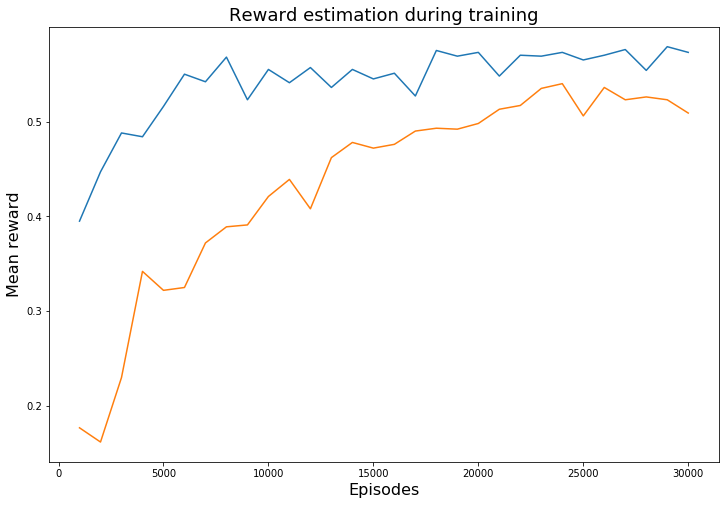

In [11]:
plt.figure(figsize = (12, 8))
plt.title('Reward estimation during training', fontsize=18)
plt.xlabel('Episodes', fontsize=16)
plt.ylabel('Mean reward', fontsize=16)
plt.plot(idx_1, crosses_1, label='Crosses')
plt.plot(idx_1, noughts_1, label='Noughts')
plt.show()

### DQN 4x4x4

In [10]:
dqn = DQN(4, 4, 4, Network_4_4, device)

total_episodes = 200000
test_episodes = 5000
num_episodes = 1000

idx_2 = []
crosses_2 = []
noughts_2 = []

for i in tqdm(range(1, total_episodes + 1)):
    dqn.run_episode(training=True)
    if i % test_episodes == 0:
        crosses = dqn.test_strategy(1, num_episodes)
        noughts = dqn.test_strategy(-1, num_episodes)
        idx_2.append(i)
        crosses_2.append(np.sum(crosses == 1) / test_episodes)
        noughts_2.append(np.sum(noughts == 1) / test_episodes)

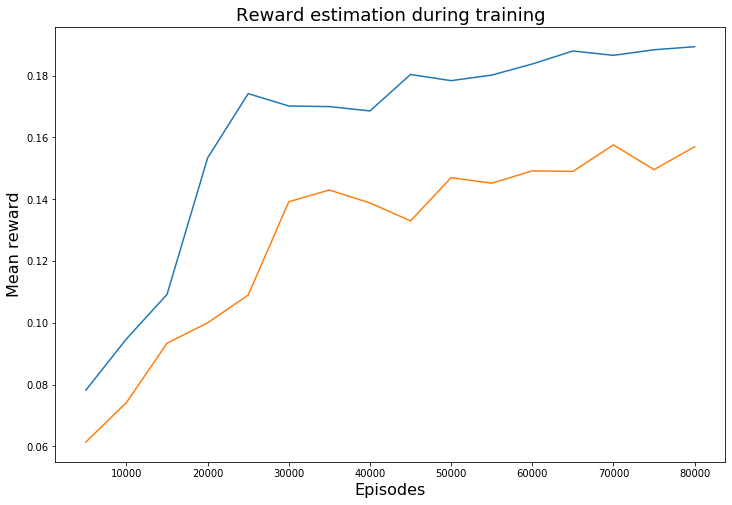

In [12]:
plt.figure(figsize = (12, 8))
plt.title('Reward estimation during training', fontsize=18)
plt.xlabel('Episodes', fontsize=16)
plt.ylabel('Mean reward', fontsize=16)
plt.plot(idx_2, crosses_2, label='Crosses')
plt.plot(idx_2, noughts_2, label='Noughts')
plt.show()

4. Реализуйте Double DQN и/или Dueling DQN.

In [13]:
class NetworkDueling_3_3(nn.Module):
    def __init__(self, conv_out=128):
        nn.Module.__init__(self)
        self.conv = nn.Conv2d(3, conv_out * 2, (3, 3))
        self.linear = nn.Linear(conv_out * 2, conv_out)
        self.v = nn.Linear(conv_out, 1)
        self.a = nn.Linear(conv_out, 9)

    def forward(self, x):
        x = F.relu(self.conv(x))
        x = torch.flatten(x, 1)
        x = F.relu(self.linear(x))
        v = self.v(x)
        a = self.a(x)
        x = v + (a - a.mean(dim=1, keepdim=True))
        return x
    
class NetworkDueling_4_4(nn.Module):
    def __init__(self):
        nn.Module.__init__(self)
        self.conv_1 = nn.Conv2d(3, 32, (3, 3))
        self.conv_2 = nn.Conv2d(32, 128, (2, 2))
        self.linear = nn.Linear(128, 64)
        self.v = nn.Linear(64, 1)
        self.a = nn.Linear(64, 16)

    def forward(self, x):
        x = F.relu(self.conv_1(x))
        x = F.relu(self.conv_2(x))
        x = torch.flatten(x, 1)
        x = F.relu(self.linear(x))
        v = self.v(x)
        a = self.a(x)
        x = v + (a - a.mean(dim=1, keepdim=True))
        return x

In [15]:
dqn = DQN(3, 3, 3, NetworkDueling_3_3, device)

total_episodes = 30000
test_episodes = 1000
num_episodes = 600

idx_3 = []
crosses_3 = []
noughts_3 = []

for i in tqdm(range(1, total_episodes + 1)):
    dqn.run_episode(training=True)
    if i % test_episodes == 0:
        crosses = dqn.test_strategy(1, num_episodes)
        noughts = dqn.test_strategy(-1, num_episodes)
        idx_3.append(i)
        crosses_3.append(np.sum(crosses == 1) / test_episodes)
        noughts_3.append(np.sum(noughts == 1) / test_episodes)

In [ ]:
plt.figure(figsize = (12, 8))
plt.title('Reward estimation during training', fontsize=18)
plt.xlabel('Episodes', fontsize=16)
plt.ylabel('Mean reward', fontsize=16)
plt.plot(idx_3, crosses_3, label='Crosses')
plt.plot(idx_3, noughts_3, label='Noughts')
plt.show()
plt.show()

In [ ]:
dqn = DQN(4, 4, 4, NetworkDueling_4_4, device)

total_episodes = 200000
test_episodes = 1000
num_episodes = 600

idx_4 = []
crosses_4 = []
noughts_4 = []

for i in tqdm(range(1, total_episodes + 1)):
    dqn.run_episode(training=True)
    if i % test_episodes == 0:
        crosses = dqn.test_strategy(1, num_episodes)
        noughts = dqn.test_strategy(-1, num_episodes)
        idx_4.append(i)
        crosses_4.append(np.sum(crosses == 1) / test_episodes)
        noughts_4.append(np.sum(noughts == 1) / test_episodes)

In [ ]:
plt.figure(figsize = (12, 8))
plt.title('Reward estimation during training', fontsize=18)
plt.xlabel('Episodes', fontsize=16)
plt.ylabel('Mean reward', fontsize=16)
plt.plot(idx_4, crosses_4, label='Crosses')
plt.plot(idx_4, noughts_4, label='Noughts')
plt.show()
plt.show()

## Часть третья: расширим и углубим поиск
Крестики-нолики -- это, конечно, далеко не го, и обычный альфа-бета поиск с отсечением здесь наверняка может работать идеально вплоть до довольно больших досок. Однако мы всё-таки для этого учебного задания будем реализовывать более практически релевантный метод MCTS -- заодно фактически получится и упражнение на многоруких бандитов.   

5. Реализуйте rollouts со случайной стратегией и (опционально) rollouts с неслучайной, но простой стратегией (например, основанной на дополнении нескольких паттернов или на Q-функции, которая у вас получилась в первом пункте). 

6. Реализуйте MCTS-поиск с этими rollouts для крестиков-ноликов на досках разного размера, сравните полученные стратегии между собой и со стратегиями, обученными в первых двух частях.